### Assessed Homework Solution - Enhancing Financial Risk Forecasting: Machine Learning with and without Macroeconomic Variables Across Market Regimes
### Candidate Number: 37279

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

In [3]:
dataset_path = '/content/drive/MyDrive/RESEARCHPROJECTDATA.csv'
data = pd.read_csv(dataset_path)
data.head()


,Unnamed: 0,PERMNO,date,TICKER,PERMCO,PRC,VOL,RET,BID,ASK,cpiret,UNRATE,GDP
0,0,14593,2001-01-02,AAPL,7,14.8750,8202806.0,0.000000,14.8750,14.9375,0.001728,4.2,10470.231
1,1,14593,2001-01-03,AAPL,7,16.3750,14854310.0,0.100840,16.3125,16.3750,0.001728,4.2,10470.231
2,2,14593,2001-01-04,AAPL,7,17.0625,13349646.0,0.041985,17.0625,17.1250,0.001728,4.2,10470.231
3,3,14593,2001-01-05,AAPL,7,16.3750,7594080.0,-0.040293,16.3750,16.4375,0.001728,4.2,10470.231
4,4,14593,2001-01-08,AAPL,7,16.5625,6768672.0,0.011450,16.5625,16.6250,0.001728,4.2,10470.231


In [4]:
data.columns

Index(['Unnamed: 0', 'PERMNO', 'date', 'TICKER', 'PERMCO', 'PRC', 'VOL', 'RET',
       'BID', 'ASK', 'cpiret', 'UNRATE', 'GDP'],
      dtype='object')

In [5]:
data.describe()

,Unnamed: 0,PERMNO,PERMCO,PRC,VOL,RET,BID,ASK,cpiret,UNRATE,GDP
count,17355.000000,17355.000000,17355.000000,17355.000000,1.735100e+04,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000,17355.000000
mean,8677.000000,36965.666667,13746.666667,78.283848,5.167230e+07,0.000644,78.263715,78.301677,0.006359,5.845462,17169.354690
std,5010.101296,24162.440680,9716.302861,113.697636,1.101223e+08,0.026500,113.687624,113.702334,0.009886,1.973576,4608.521707
min,0.000000,14593.000000,7.000000,1.020000,7.194360e+05,-0.390244,1.010000,1.020000,-0.039102,3.400000,10470.231000
25%,4338.500000,14593.000000,7.000000,13.060000,1.451281e+07,-0.010503,13.060000,13.070000,0.000663,4.400000,14039.560000
50%,8677.000000,25785.000000,20483.000000,43.210000,2.608586e+07,0.000138,43.210000,43.240000,0.006207,5.400000,16319.541000
75%,13015.500000,70519.000000,20750.000000,80.755000,4.854119e+07,0.011491,80.740000,80.765000,0.012291,6.700000,20037.088000
max,17354.000000,70519.000000,20750.000000,702.099980,1.897900e+09,0.578249,702.109990,702.179990,0.031212,14.800000,28296.967000


## Data Preprocessing and feature engineering

In [6]:
# 1. Handle Missing Values
data = data.dropna(subset=['PRC', 'RET', 'BID', 'ASK', 'cpiret', 'UNRATE', 'GDP'])

# 2. Date Formatting
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# 3. Remove Duplicates
data = data.drop_duplicates(subset=['PERMNO', 'date'])

# 4. Filter Relevant Data
selected_tickers = ['AAPL', 'C', 'F']
data = data[data['TICKER'].isin(selected_tickers)]

# 5. Calculate Log Returns
data['LogReturn'] = data.groupby('TICKER')['PRC'].transform(lambda x: np.log(x / x.shift(1)))

# 6. Normalize Macroeconomic Variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['cpiret_norm', 'UNRATE_norm', 'GDP_norm']] = scaler.fit_transform(
    data[['cpiret', 'UNRATE', 'GDP']]
)

# 7. Feature Engineering
# Lagged Features
for lag in range(1, 4):
    data[f'RET_Lag{lag}'] = data.groupby('TICKER')['RET'].transform(lambda x: x.shift(lag))
    data[f'cpiret_Lag{lag}'] = data['cpiret'].shift(lag)
    data[f'UNRATE_Lag{lag}'] = data['UNRATE'].shift(lag)

# Rolling Volatility
data['Volatility'] = data.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=20).std())

# Moving Averages
data['MA_20'] = data.groupby('TICKER')['PRC'].transform(lambda x: x.rolling(window=20).mean())
data['MA_50'] = data.groupby('TICKER')['PRC'].transform(lambda x: x.rolling(window=50).mean())

# MACD
data['EMA_12'] = data.groupby('TICKER')['PRC'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
data['EMA_26'] = data.groupby('TICKER')['PRC'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
data['MACD'] = data['EMA_12'] - data['EMA_26']

# RSI
data['Delta'] = data.groupby('TICKER')['PRC'].diff()
data['Gain'] = data['Delta'].where(data['Delta'] > 0, 0).groupby(data['TICKER']).transform(lambda x: x.rolling(window=14).mean())
data['Loss'] = -data['Delta'].where(data['Delta'] < 0, 0).groupby(data['TICKER']).transform(lambda x: x.rolling(window=14).mean())
data['RSI'] = 100 - (100 / (1 + data['Gain'] / data['Loss']))

# Bid-Ask Spread
data['Spread'] = data['ASK'] - data['BID']

# Market Regime Classification
data['CumulativeReturn'] = data.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=30).sum())
data['MarketRegime'] = np.where(
    data['CumulativeReturn'] > 0, 'Bull',
    np.where(data['CumulativeReturn'] < -0.05, 'Bear', 'Crisis')
)

# Interaction Features
data['RET_cpiret'] = data['RET'] * data['cpiret']
data['RET_UNRATE'] = data['RET'] * data['UNRATE']

# Drop rows with NaN values introduced during feature engineering
data = data.dropna()
data

,Unnamed: 0,PERMNO,date,TICKER,PERMCO,PRC,VOL,RET,BID,ASK,...,MACD,Delta,Gain,Loss,RSI,Spread,CumulativeReturn,MarketRegime,RET_cpiret,RET_UNRATE
49,49,14593,2001-03-14,AAPL,7,20.4375,8669722.0,0.044728,20.3125,20.375,...,0.254107,0.8750,0.410714,0.294643,58.227848,0.0625,-0.040451,Crisis,0.000077,0.192330
50,50,14593,2001-03-15,AAPL,7,19.6875,9613365.0,-0.036697,19.6875,19.750,...,0.218264,-0.7500,0.410714,0.348214,54.117647,0.0625,-0.071401,Bear,-0.000063,-0.157797
51,51,14593,2001-03-16,AAPL,7,19.6250,8619541.0,-0.003175,19.5625,19.625,...,0.182710,-0.0625,0.361607,0.352679,50.625000,0.0625,-0.051455,Bear,-0.000005,-0.013652
52,52,14593,2001-03-19,AAPL,7,20.5625,6593095.0,0.047771,20.5625,20.625,...,0.227558,0.9375,0.428571,0.343750,55.491329,0.0625,0.019985,Bull,0.000083,0.205415
53,53,14593,2001-03-20,AAPL,7,19.6875,9255088.0,-0.042553,19.6875,19.750,...,0.190301,-0.8750,0.428571,0.325893,56.804734,0.0625,-0.001356,Crisis,-0.000074,-0.182978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17350,17350,70519,2023-12-22,C,20483,50.8600,14440560.0,0.005138,50.8600,50.870,...,1.784637,0.2600,0.459286,0.210000,68.623266,0.0100,0.206812,Bull,0.000045,0.019524
17351,17351,70519,2023-12-26,C,20483,51.3400,11501461.0,0.009438,51.3300,51.340,...,1.799032,0.4800,0.493571,0.162143,75.272331,0.0100,0.202274,Bull,0.000083,0.035864
17352,17352,70519,2023-12-27,C,20483,51.4600,9901341.0,0.002337,51.4600,51.470,...,1.799381,0.1200,0.419286,0.162143,72.113022,0.0100,0.189877,Bull,0.000021,0.008881
17353,17353,70519,2023-12-28,C,20483,51.5200,10218453.0,0.001166,51.5300,51.540,...,1.783934,0.0600,0.377857,0.162143,69.973545,0.0100,0.152167,Bull,0.000010,0.004431


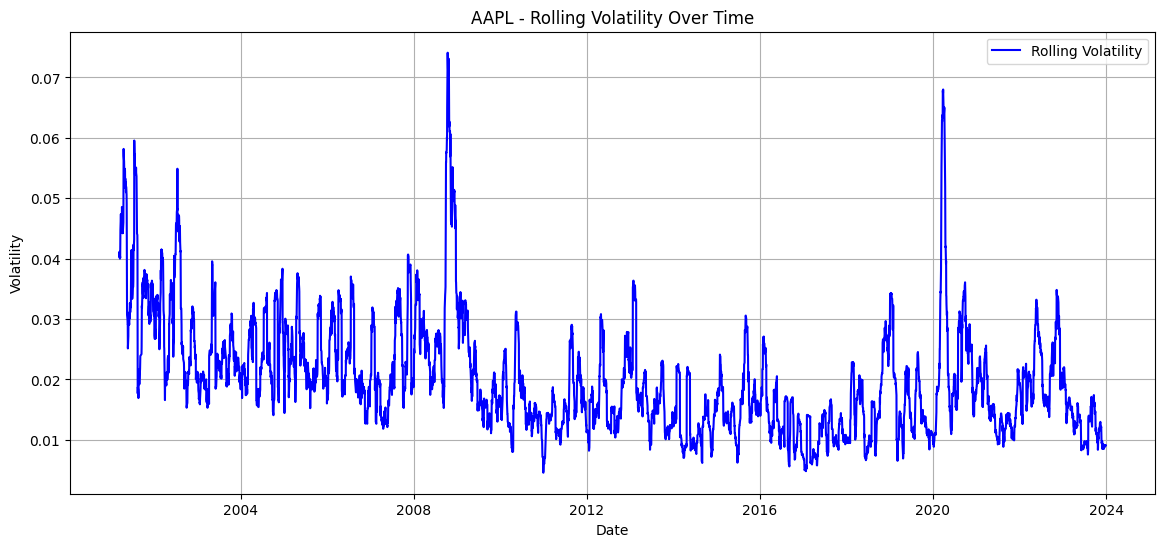

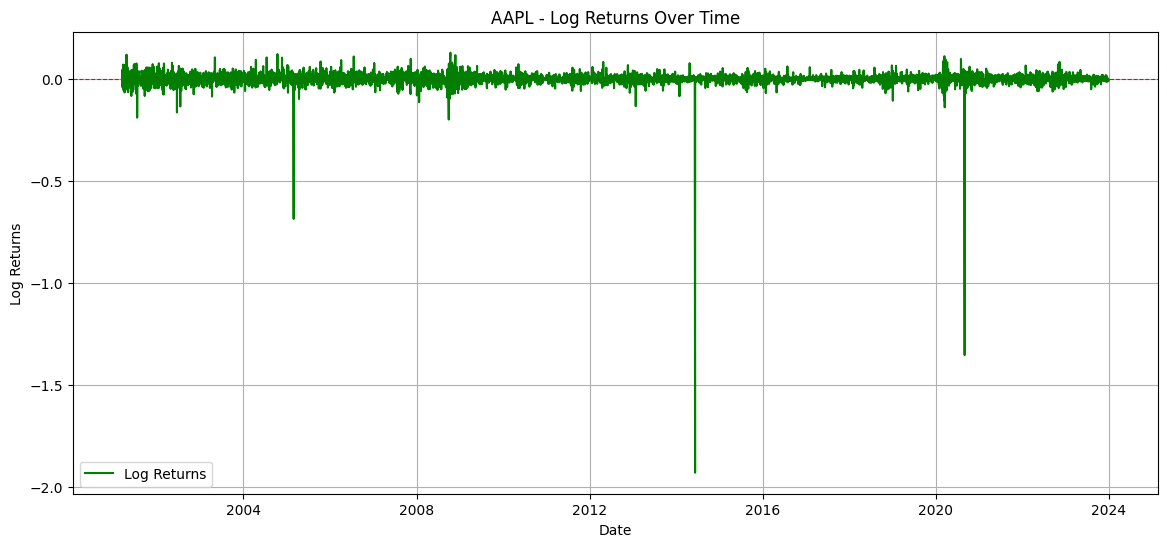

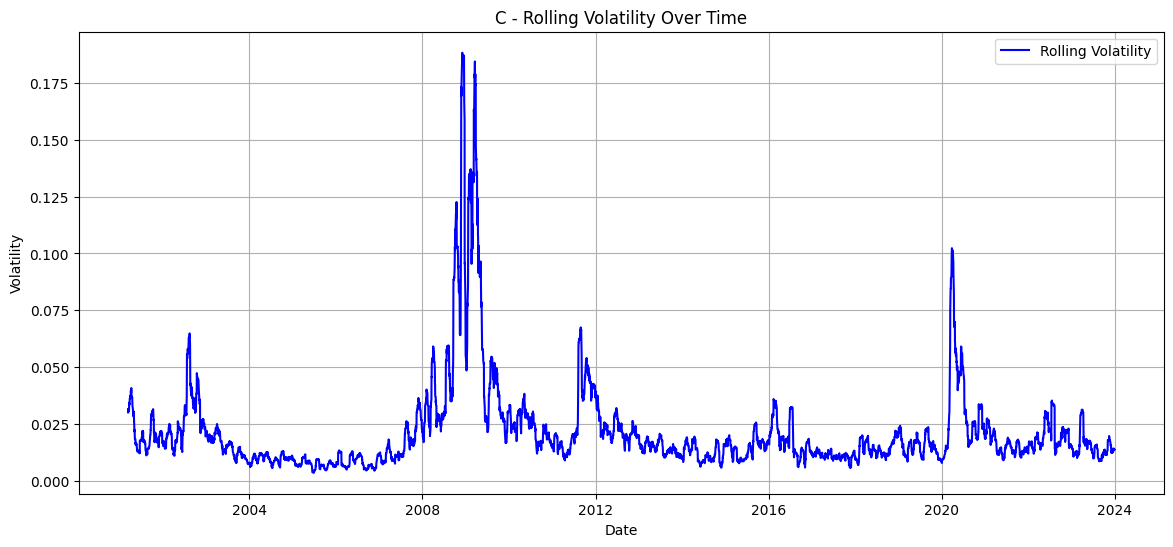

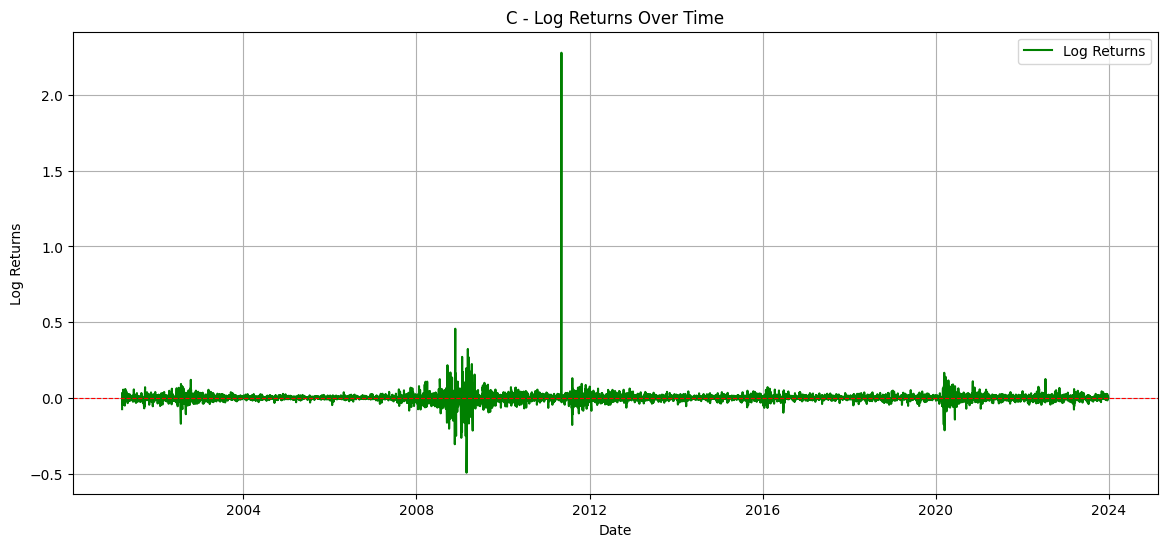

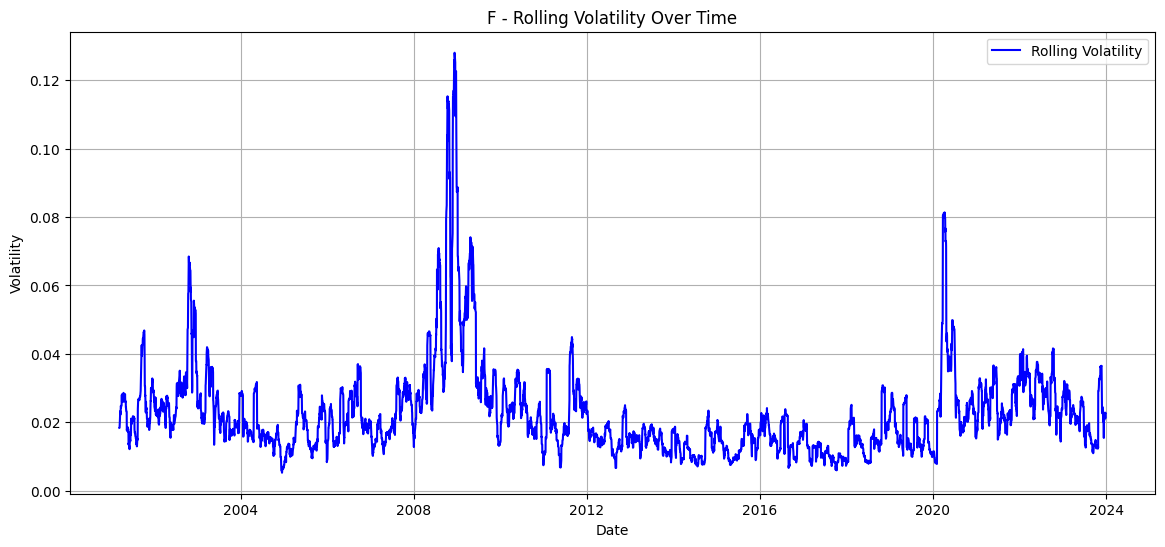

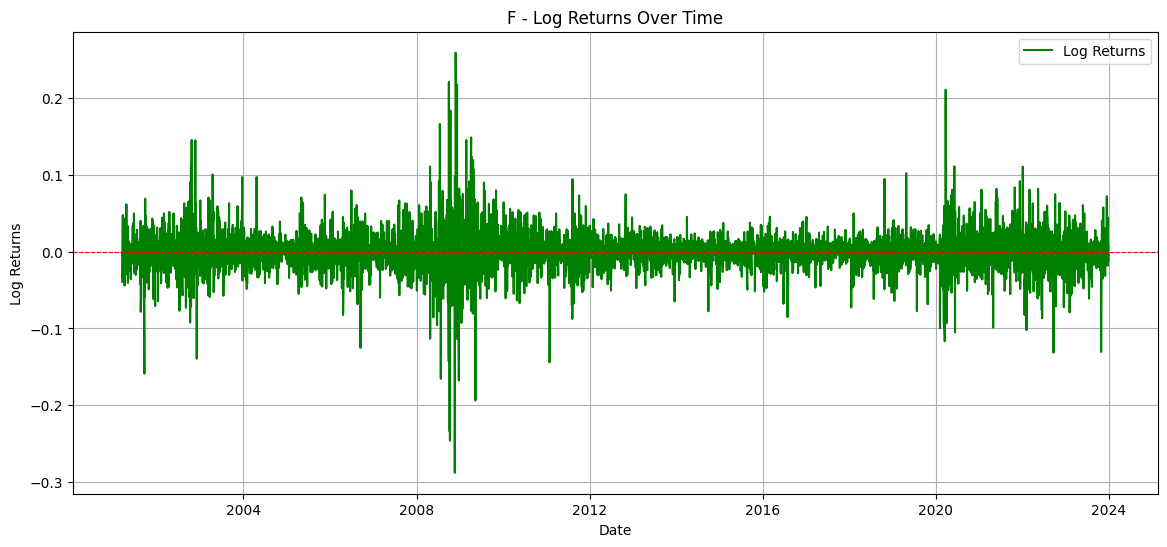

In [7]:
# Function to plot rolling volatility and returns for each ticker
def plot_volatility_and_returns(data, tickers, rolling_col='Volatility', return_col='LogReturn'):

    for ticker in tickers:
        ticker_data = data[data['TICKER'] == ticker]

        # Plot Rolling Volatility
        plt.figure(figsize=(14, 6))
        plt.plot(ticker_data['date'], ticker_data[rolling_col], label='Rolling Volatility', color='blue')
        plt.title(f"{ticker} - Rolling Volatility Over Time")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Log Returns
        plt.figure(figsize=(14, 6))
        plt.plot(ticker_data['date'], ticker_data[return_col], label='Log Returns', color='green')
        plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
        plt.title(f"{ticker} - Log Returns Over Time")
        plt.xlabel("Date")
        plt.ylabel("Log Returns")
        plt.legend()
        plt.grid(True)
        plt.show()

# List of tickers to visualize
selected_tickers = ['AAPL', 'C', 'F']

# Call the function
plot_volatility_and_returns(data, selected_tickers)


In [8]:
data.columns

Index(['Unnamed: 0', 'PERMNO', 'date', 'TICKER', 'PERMCO', 'PRC', 'VOL', 'RET',
       'BID', 'ASK', 'cpiret', 'UNRATE', 'GDP', 'LogReturn', 'cpiret_norm',
       'UNRATE_norm', 'GDP_norm', 'RET_Lag1', 'cpiret_Lag1', 'UNRATE_Lag1',
       'RET_Lag2', 'cpiret_Lag2', 'UNRATE_Lag2', 'RET_Lag3', 'cpiret_Lag3',
       'UNRATE_Lag3', 'Volatility', 'MA_20', 'MA_50', 'EMA_12', 'EMA_26',
       'MACD', 'Delta', 'Gain', 'Loss', 'RSI', 'Spread', 'CumulativeReturn',
       'MarketRegime', 'RET_cpiret', 'RET_UNRATE'],
      dtype='object')

## Data visualization

### Correlation matrix

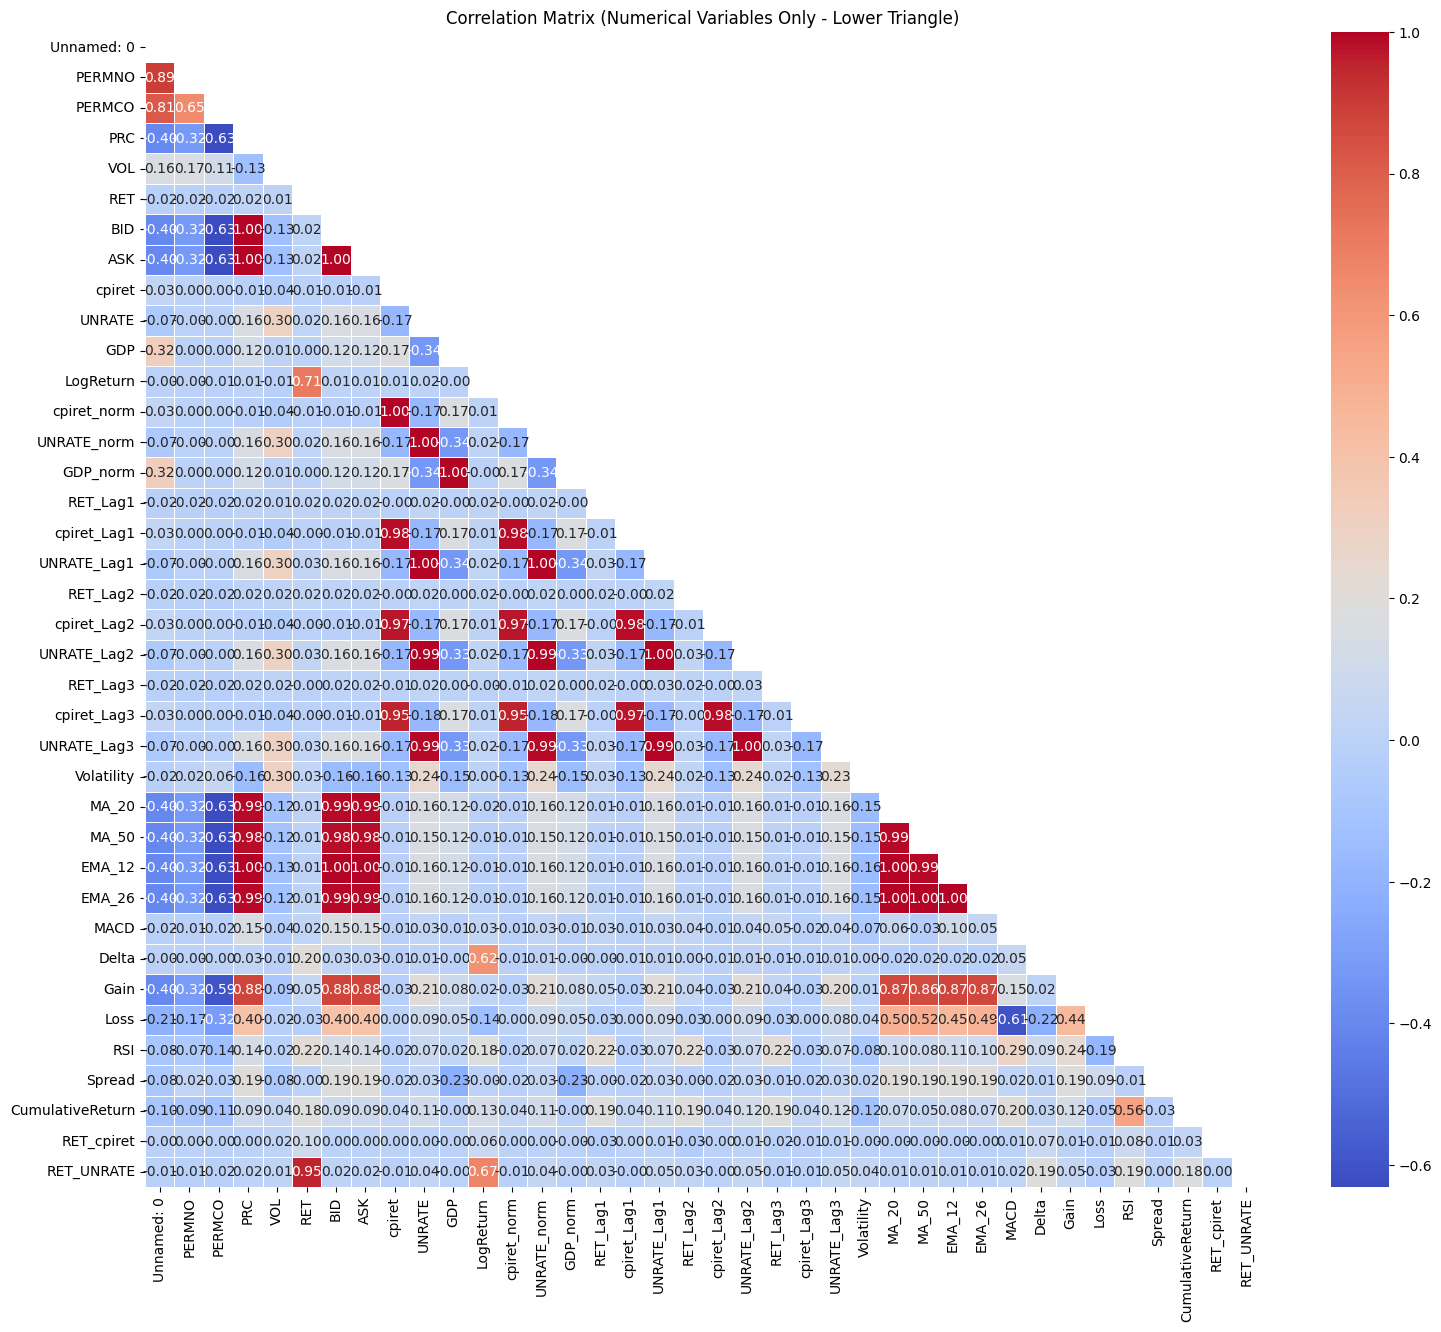

In [9]:
# 1. Correlation Matrix (Numerical Variables Only)
numerical_data = data.select_dtypes(include=[np.number])
correlation_matrix = numerical_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Numerical Variables Only - Lower Triangle)')
plt.show()

### Time-Series comparison: MACD and RSI

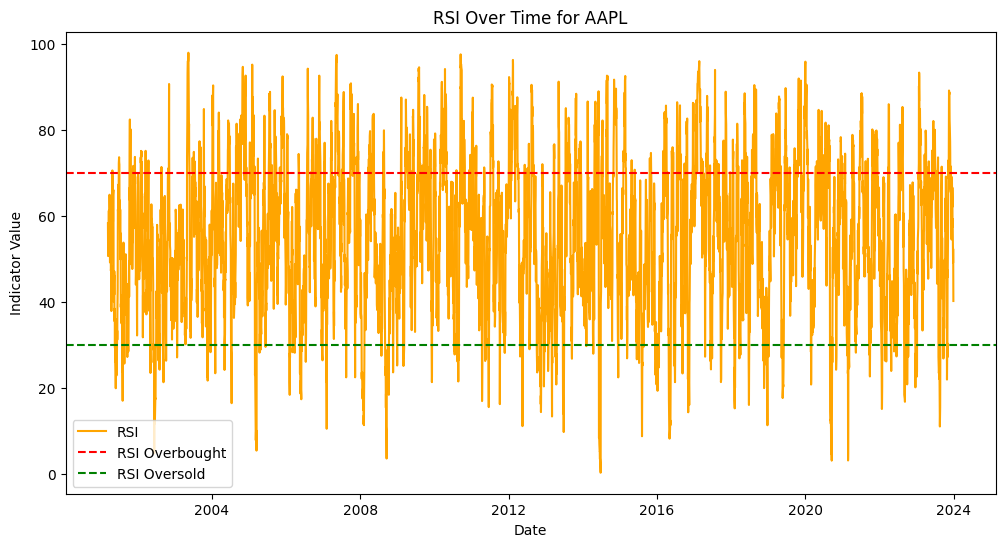

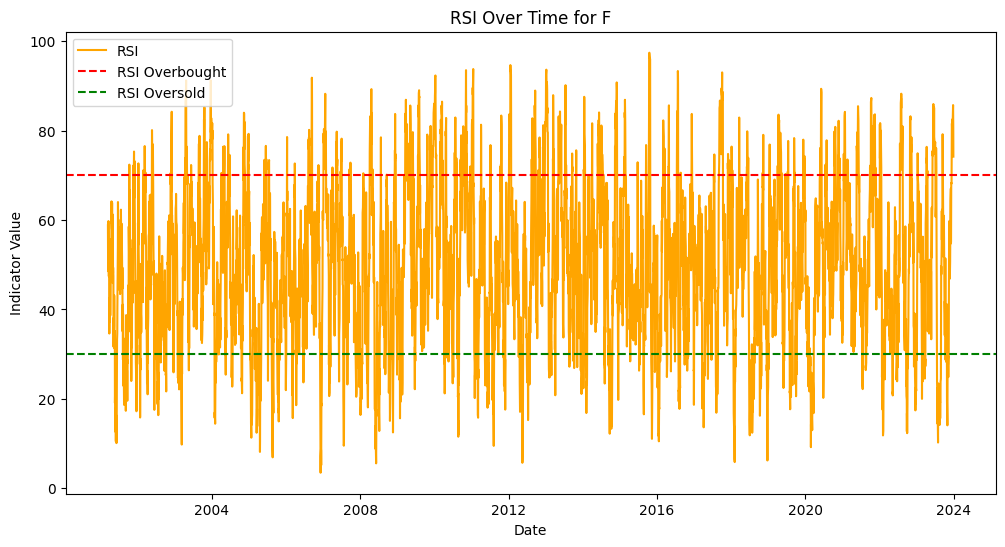

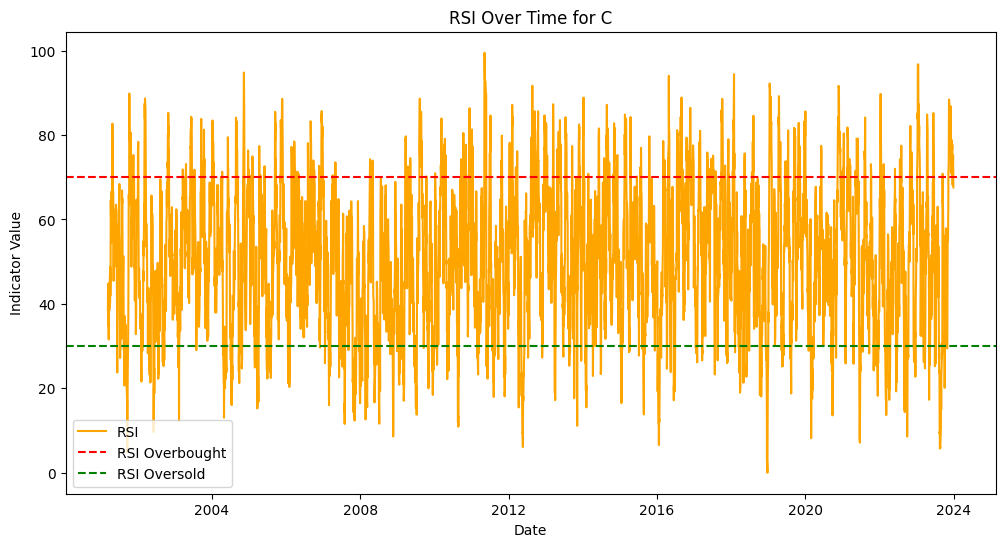

In [10]:
# 3. Time-Series Comparison: RSI
for ticker in data['TICKER'].unique():
    ticker_data = data[data['TICKER'] == ticker]
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data['date'], ticker_data['RSI'], label='RSI', color='orange')
    plt.axhline(y=70, color='red', linestyle='--', label='RSI Overbought')
    plt.axhline(y=30, color='green', linestyle='--', label='RSI Oversold')
    plt.title(f'RSI Over Time for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Indicator Value')
    plt.legend()
    plt.show()

### Closing Price and Moving Averages Over Time

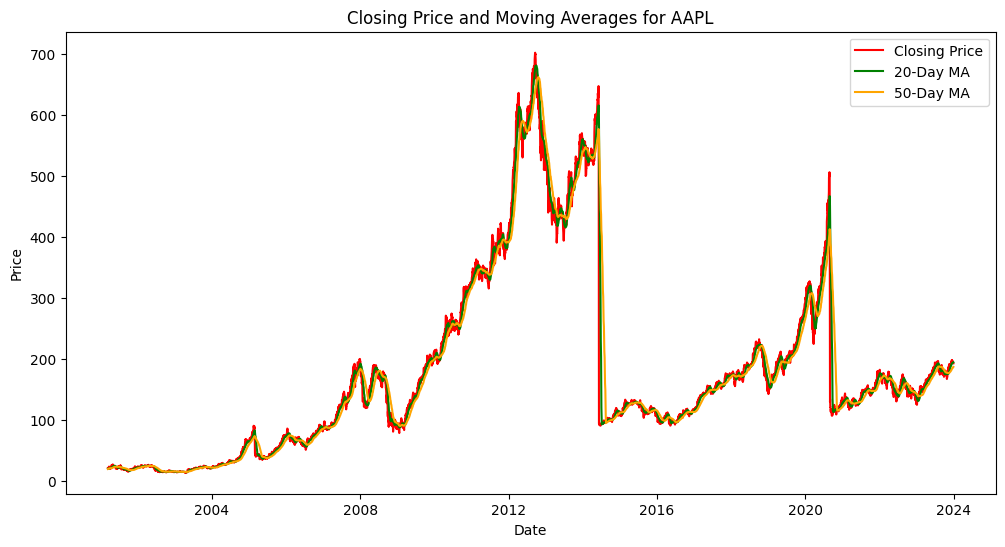

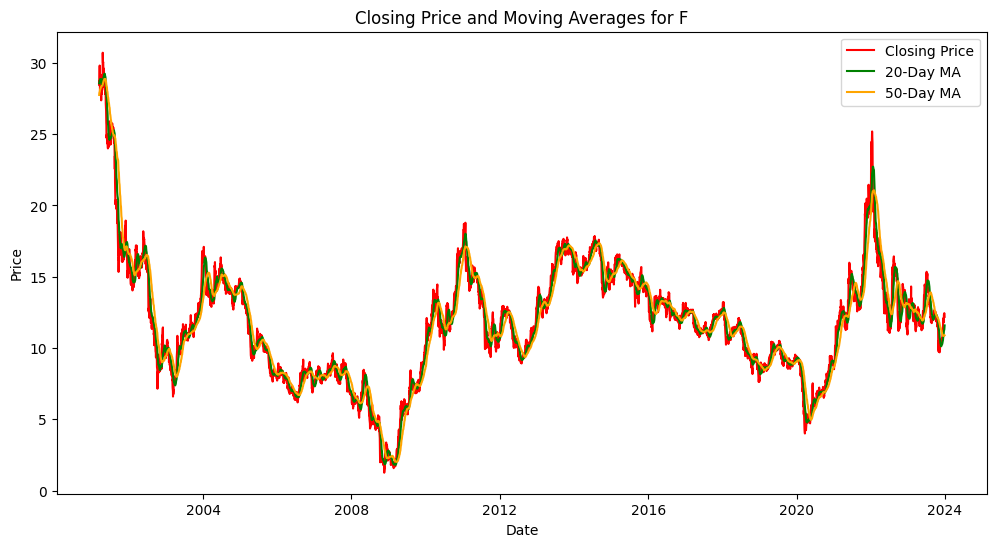

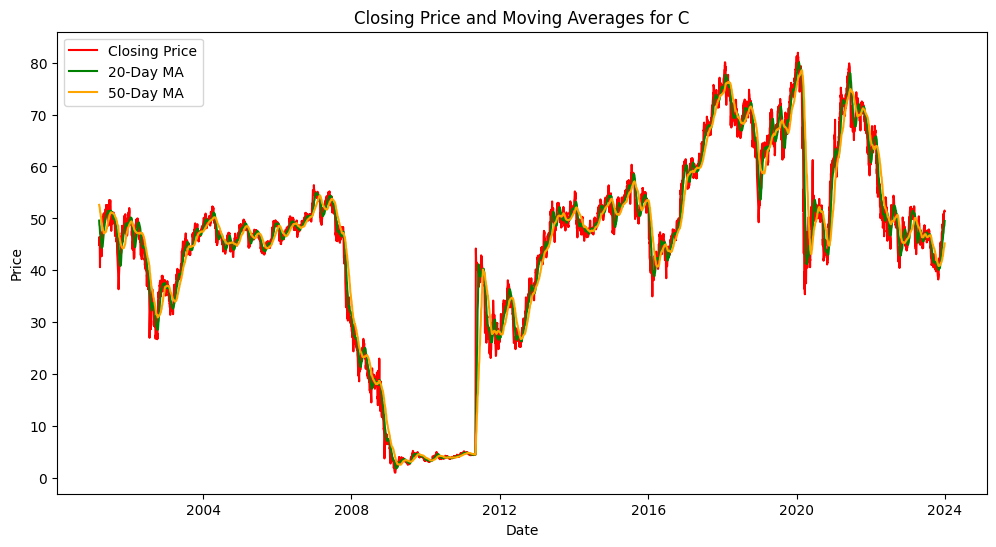

In [11]:
# 4. Closing Price and Moving Averages Over Time
for ticker in data['TICKER'].unique():
    ticker_data = data[data['TICKER'] == ticker]
    plt.figure(figsize=(12, 6))
    plt.plot(ticker_data['date'], ticker_data['PRC'], label='Closing Price', color='red')
    plt.plot(ticker_data['date'], ticker_data['MA_20'], label='20-Day MA', color='green')
    plt.plot(ticker_data['date'], ticker_data['MA_50'], label='50-Day MA', color='orange')
    plt.title(f'Closing Price and Moving Averages for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## Model Implementation and Performance Analysis

In [12]:
data.columns

Index(['Unnamed: 0', 'PERMNO', 'date', 'TICKER', 'PERMCO', 'PRC', 'VOL', 'RET',
       'BID', 'ASK', 'cpiret', 'UNRATE', 'GDP', 'LogReturn', 'cpiret_norm',
       'UNRATE_norm', 'GDP_norm', 'RET_Lag1', 'cpiret_Lag1', 'UNRATE_Lag1',
       'RET_Lag2', 'cpiret_Lag2', 'UNRATE_Lag2', 'RET_Lag3', 'cpiret_Lag3',
       'UNRATE_Lag3', 'Volatility', 'MA_20', 'MA_50', 'EMA_12', 'EMA_26',
       'MACD', 'Delta', 'Gain', 'Loss', 'RSI', 'Spread', 'CumulativeReturn',
       'MarketRegime', 'RET_cpiret', 'RET_UNRATE'],
      dtype='object')

## Model Performance and analysis of the all the dataset

In [15]:
# Step 1: Regime Classification
# Apply a threshold-based approach to classify market regimes (bull, bear, crisis) based on returns and volatility.
data['MarketRegime'] = np.where(
    data['RET'] > 0.02, 'Bull',
    np.where(data['RET'] < -0.02, 'Bear', 'Crisis')
)
data = pd.get_dummies(data, columns=['MarketRegime'], drop_first=True)


# Prepare data
data['date'] = pd.to_datetime(data['date'])
data.dropna(inplace=True)
sequence_length = 10
n_splits = 2
target = 'PRC'
features = data.drop(columns=[target, 'date', 'TICKER']).columns

def calculate_metrics(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return mse, rmse, mae, mape, r2, adj_r2

def calculate_var_es(predictions, alpha=0.95):
    var = np.percentile(predictions, (1 - alpha) * 100)
    es = predictions[predictions <= var].mean()
    return var, es

ts_results = {}
for ticker in data['TICKER'].unique():
    ticker_data = data[data['TICKER'] == ticker]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results_dict = {
        'LSTM': [],
        'GRU': [],
        'GBM': []
    }

    # Cross-validation for LSTM and GRU
    for model_name in ['LSTM', 'GRU']:
        for fold, (train_index, test_index) in enumerate(tscv.split(ticker_data[target].values)):
            print(f"{ticker} - {model_name}: Processing fold {fold+1}/{n_splits}")

            train, test = ticker_data[target].values[train_index], ticker_data[target].values[test_index]

            generator = TimeseriesGenerator(train, train, length=sequence_length, batch_size=1)
            X_train, y_train = [], []
            for i in range(len(generator)):
                x_, y_ = generator[i]
                X_train.append(x_)
                y_train.append(y_)
            X_train = np.array(X_train).squeeze()
            y_train = np.array(y_train)

            generator = TimeseriesGenerator(test, test, length=sequence_length, batch_size=1)
            X_test, y_test = [], []
            for i in range(len(generator)):
                x_, y_ = generator[i]
                X_test.append(x_)
                y_test.append(y_)
            X_test = np.array(X_test).squeeze()
            y_test = np.array(y_test)

            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

            # Build and train the model
            if model_name == 'LSTM':
                model = Sequential([
                    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
                    Dense(1)
                ])
            else:
                model = Sequential([
                    GRU(50, activation='relu', input_shape=(sequence_length, 1)),
                    Dense(1)
                ])

            model.compile(optimizer='adam', loss='mse')
            model.fit(X_train, y_train, epochs=20, verbose=1)

            # Make predictions
            predictions = model.predict(X_test).flatten()

            # Calculate metrics
            mse, rmse, mae, mape, r2, adj_r2 = calculate_metrics(y_test, predictions, len(y_test), X_test.shape[1])
            var_95, es_95 = calculate_var_es(predictions, alpha=0.95)
            var_99, es_99 = calculate_var_es(predictions, alpha=0.99)

            results_dict[model_name].append((mse, rmse, mae, mape, r2, adj_r2, var_95, es_95, var_99, es_99))

    # Cross-validation for GBM
    for fold, (train_index, test_index) in enumerate(tscv.split(ticker_data[target].values)):
        print(f"{ticker} - GBM: Processing fold {fold+1}/{n_splits}")

        X_train, X_test = ticker_data.iloc[train_index][features], ticker_data.iloc[test_index][features]
        y_train, y_test = ticker_data.iloc[train_index][target], ticker_data.iloc[test_index][target]

        gbm = GradientBoostingRegressor()
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        gbm.fit(X_train_scaled, y_train)
        gbm_pred = gbm.predict(X_test_scaled)

        mse, rmse, mae, mape, r2, adj_r2 = calculate_metrics(y_test, gbm_pred, len(y_test), X_test_scaled.shape[1])
        var_95, es_95 = calculate_var_es(gbm_pred, alpha=0.95)
        var_99, es_99 = calculate_var_es(gbm_pred, alpha=0.99)

        results_dict['GBM'].append((mse, rmse, mae, mape, r2, adj_r2, var_95, es_95, var_99, es_99))

    ts_results[ticker] = results_dict

# Evaluation Metrics
# Results per ticker:
for ticker, results_dict in ts_results.items():
    print(f"{ticker} Results:")
    for model, metrics in results_dict.items():
        avg_metrics = np.mean(metrics, axis=0)
        print(f"{model}: MSE={avg_metrics[0]:.2f}, RMSE={avg_metrics[1]:.2f}, MAE={avg_metrics[2]:.2f}, MAPE={avg_metrics[3]:.2f}%, R²={avg_metrics[4]:.2f}, Adj R²={avg_metrics[5]:.2f}, VaR_95={avg_metrics[6]:.2f}, ES_95={avg_metrics[7]:.2f}, VaR_99={avg_metrics[8]:.2f}, ES_99={avg_metrics[9]:.2f}")


AAPL - LSTM: Processing fold 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 4358.2793
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 28.1577 
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.9889
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 19.1455
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.9717
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.8683
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.1731
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.9994
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.7366
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.6071
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.1775
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.4025
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.2136
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.9953
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.1151
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 10928.7666
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 107.1401
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 142.5825
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 226.3979
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 356.0916
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 435.3308
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 395.3153
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 157.6123
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 221.9369
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 195.9205
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 158.8289
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 163.8749
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 246.0404
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 390.7512
Epoch 15/20
120/120 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 5719.7651
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 18.0708
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.2617
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2667
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.3388
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9697
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1890
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.7509
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1442
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.0654
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.0846
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.6453
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.5317
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3587
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.9911
Epoch 16/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 38247.5547
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 124.2822
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 52.2655
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 117.6780
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 46.1537
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 141.4975
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 399.9277
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 48.2766
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 90.9590
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 270.1253
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 119.7135
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 56.8048
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 71.3280
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 94.0853
Epoch 15/20
120/120 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 52.5918
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2245
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1882
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1774
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1978
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1548
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1298
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1289
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1340
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1221
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1205
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1142
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1328
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1365
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1048
Epoch 16/20
60/60 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 38.3387
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2519
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2235
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1642
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1476
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1235
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1236
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1136
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1118
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1083
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0908
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1062
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0940
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0948
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 69.6576
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3087
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1664
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1534
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1400
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1195
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1191
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1242
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1095
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1187
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1067
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1083
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1140
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1082
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0910
Epoch 16/20
60/60 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 54.9280
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1539
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1364
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1311
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1419
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1181
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1204
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1212
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1175
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1244
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0969
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1134
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0992
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1050
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 389.3253
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1336
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0377
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8371
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7824
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8080
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7017
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6395
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6334
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7046
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6324
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6647
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5863
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6857
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6440
Epoch 16/20
60/60 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 579.4327
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5040
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0910
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3860
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2851
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6786
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1286
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1246
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0783
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1103
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6947
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0387
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6991
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9532
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1389.2072
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2795
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8615
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7816
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8617
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8456
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8950
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8031
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8621
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8474
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8504
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8988
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8022
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7739
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7963
Epoch 16/20
60/60 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 576.1222
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4149
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6791
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2009
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1968
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4267
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7189
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7470
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2555
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1875
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8230
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6389
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.8038
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7198
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0

## Model Performance and Analysis without macroeconomic variables

In [16]:
# Prepare data
data['date'] = pd.to_datetime(data['date'])
data.dropna(inplace=True)

# Target and features
target = 'PRC'
exclude_features = ['cpiret', 'UNRATE', 'GDP', 'cpiret_Lag1', 'UNRATE_Lag1', 'GDP_Lag1',
                    'cpiret_Lag2', 'UNRATE_Lag2', 'GDP_Lag2', 'cpiret_Lag3', 'UNRATE_Lag3', 'GDP_Lag3']
features = [col for col in data.columns if col not in exclude_features + [target, 'date', 'TICKER']]
print(f"Features used for training: {features}")

# Time-series split and model training using features
sequence_length = 10
n_splits = 2

# Time-series cross-validation and evaluation
ts_results = {}
for ticker in data['TICKER'].unique():
    ticker_data = data[data['TICKER'] == ticker]
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results_dict = {
        'LSTM': [],
        'GRU': [],
        'GBM': []
    }

    # Cross-validation for LSTM and GRU
    for model_name in ['LSTM', 'GRU']:
        for fold, (train_index, test_index) in enumerate(tscv.split(ticker_data[target].values)):
            print(f"{ticker} - {model_name}: Processing fold {fold+1}/{n_splits}")

            train, test = ticker_data[target].values[train_index], ticker_data[target].values[test_index]

            generator = TimeseriesGenerator(train, train, length=sequence_length, batch_size=1)
            X_train, y_train = [], []
            for i in range(len(generator)):
                x_, y_ = generator[i]
                X_train.append(x_)
                y_train.append(y_)
            X_train = np.array(X_train).squeeze()
            y_train = np.array(y_train)

            generator = TimeseriesGenerator(test, test, length=sequence_length, batch_size=1)
            X_test, y_test = [], []
            for i in range(len(generator)):
                x_, y_ = generator[i]
                X_test.append(x_)
                y_test.append(y_)
            X_test = np.array(X_test).squeeze()
            y_test = np.array(y_test)

            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

            # Build and train the model
            if model_name == 'LSTM':
                model = Sequential([
                    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
                    Dense(1)
                ])
            else:
                model = Sequential([
                    GRU(50, activation='relu', input_shape=(sequence_length, 1)),
                    Dense(1)
                ])

            model.compile(optimizer='adam', loss='mse')
            model.fit(X_train, y_train, epochs=20, verbose=1)

            # Make predictions
            predictions = model.predict(X_test).flatten()

            # Calculate metrics
            mse, rmse, mae, mape, r2, adj_r2 = calculate_metrics(y_test, predictions, len(y_test), X_test.shape[1])
            var_95, es_95 = calculate_var_es(predictions, alpha=0.95)
            var_99, es_99 = calculate_var_es(predictions, alpha=0.99)

            results_dict[model_name].append((mse, rmse, mae, mape, r2, adj_r2, var_95, es_95, var_99, es_99))

    # Cross-validation for GBM
    for fold, (train_index, test_index) in enumerate(tscv.split(ticker_data[target].values)):
        print(f"{ticker} - GBM: Processing fold {fold+1}/{n_splits}")

        X_train, X_test = ticker_data.iloc[train_index][features], ticker_data.iloc[test_index][features]
        y_train, y_test = ticker_data.iloc[train_index][target], ticker_data.iloc[test_index][target]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        gbm = GradientBoostingRegressor()
        gbm.fit(X_train_scaled, y_train)
        gbm_pred = gbm.predict(X_test_scaled)

        mse, rmse, mae, mape, r2, adj_r2 = calculate_metrics(y_test, gbm_pred, len(y_test), X_test_scaled.shape[1])
        var_95, es_95 = calculate_var_es(gbm_pred, alpha=0.95)
        var_99, es_99 = calculate_var_es(gbm_pred, alpha=0.99)

        results_dict['GBM'].append((mse, rmse, mae, mape, r2, adj_r2, var_95, es_95, var_99, es_99))

    ts_results[ticker] = results_dict

# Evaluation Metrics
# Results per ticker:
for ticker, results_dict in ts_results.items():
    print(f"{ticker} Results:")
    for model, metrics in results_dict.items():
        avg_metrics = np.mean(metrics, axis=0)
        print(f"{model}: MSE={avg_metrics[0]:.2f}, RMSE={avg_metrics[1]:.2f}, MAE={avg_metrics[2]:.2f}, MAPE={avg_metrics[3]:.2f}%, R²={avg_metrics[4]:.2f}, Adj R²={avg_metrics[5]:.2f}, VaR_95={avg_metrics[6]:.2f}, ES_95={avg_metrics[7]:.2f}, VaR_99={avg_metrics[8]:.2f}, ES_99={avg_metrics[9]:.2f}")


Features used for training: ['Unnamed: 0', 'PERMNO', 'PERMCO', 'VOL', 'RET', 'BID', 'ASK', 'LogReturn', 'cpiret_norm', 'UNRATE_norm', 'GDP_norm', 'RET_Lag1', 'RET_Lag2', 'RET_Lag3', 'Volatility', 'MA_20', 'MA_50', 'EMA_12', 'EMA_26', 'MACD', 'Delta', 'Gain', 'Loss', 'RSI', 'Spread', 'CumulativeReturn', 'RET_cpiret', 'RET_UNRATE', 'MarketRegime_Bull', 'MarketRegime_Crisis']
AAPL - LSTM: Processing fold 1/2
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3984.3035
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.1984
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.3403
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.8667
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.0550
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.9317
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.9124
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.6022
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 12.7446
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.7410
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 11.7398
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7387
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13.1996
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1415
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.2534
Epoch 16/20

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7346.5820
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 280.8095
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 208.1030
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 255.8097
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 196.2784
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 216.6211
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 200.7798
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 124.4374
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 112.6300
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 134.8273
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 154.5640
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 157.1157
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 103.6912
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 119.7043
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5177.4468
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 50.3134
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.6034
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3346
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.4126
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.2748
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4860
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.0675
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1543
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.1465
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.3320
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7443
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6670
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.9892
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.1010
Epoch 16/20
60/60 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 23520.2051
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 43.6356
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 133.9546
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 309.0231
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 44.8854
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 101.8139
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 197.8907
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 39.0705
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 265.3308
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 157.4411
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 43.4314
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 77.9054
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 71.5678
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 85.6343
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 79.8922
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5730
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4049
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3191
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2706
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2438
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1665
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1917
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1803
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1632
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1535
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1440
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1463
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1336
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1438
Epoch 16/20
60/60 ━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 22.5676
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3172
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1355
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1214
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1121
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1111
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1075
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1035
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1187
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0926
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1082
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0878
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0979
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0859
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.078

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 94.0951
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2495
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1649
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1594
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1509
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1542
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1413
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1368
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1292
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1408
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1318
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1486
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1267
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1149
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1111
Epoch 16/20
60/60 ━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 65.9967
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1671
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1633
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1312
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1331
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1098
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1149
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1172
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1097
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0962
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1076
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0910
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0864
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0974
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 113.4481
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4126
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1985
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9440
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9598
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8574
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9021
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8745
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7291
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7422
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8186
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7216
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6835
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7819
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6840
Epoch 16/20
60

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 410.9561
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8836
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6585
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7700
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0034
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4875
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6380
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2038
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8620
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8783
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7378
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3438
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7323
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5602
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.376

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1320.2278
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4358
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9963
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9995
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8655
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8946
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6686
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7532
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7553
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7844
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6702
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6999
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6662
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7811
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.7305
Epoch 16/20
60/60 ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 803.1036
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1055
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4127
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3910
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4630
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0449
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1105
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8530
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5829
Epoch 10/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8516
Epoch 11/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7502
Epoch 12/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9304
Epoch 13/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9182
Epoch 14/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8938
Epoch 15/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

## Regime Switch all dataset

In [17]:
data['MarketRegime'] = np.where(
    data['RET'] > 0.02, 'Bull',
    np.where(data['RET'] < -0.02, 'Bear', 'Crisis')
)

# Fit Markov Switching Model on returns
markov_model = MarkovRegression(data['RET'], k_regimes=3, trend='c', switching_variance=True)
markov_results = markov_model.fit()

# Add predicted regimes to the dataset
data['MarkovRegime'] = markov_results.predict()

# Segment Data by Regime and Evaluate Model Performance
regime_results = {}

for regime in ['Bull', 'Bear', 'Crisis']:
    print(f"Evaluating models for {regime} regime")
    regime_data = data[data['MarketRegime'] == regime]

    # Prepare data for modeling
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results_dict = {'LSTM': [], 'GRU': [], 'GBM': []}

    for model_name in ['LSTM', 'GRU']:
        for fold, (train_index, test_index) in enumerate(tscv.split(regime_data[target].values)):
            print(f"Processing {model_name} for fold {fold + 1} in {regime}")
            train, test = regime_data.iloc[train_index], regime_data.iloc[test_index]

            # Sequence generation
            generator = TimeseriesGenerator(train[target].values, train[target].values, length=sequence_length, batch_size=1)

            # Build LSTM/GRU Model
            if model_name == 'LSTM':
                model = Sequential([
                    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
                    Dense(1)
                ])
            else:
                model = Sequential([
                    GRU(50, activation='relu', input_shape=(sequence_length, 1)),
                    Dense(1)
                ])

            model.compile(optimizer='adam', loss='mse')
            model.fit(generator, epochs=20, verbose=1)

            # Predictions and Metrics
            test_generator = TimeseriesGenerator(test[target].values, test[target].values, length=sequence_length, batch_size=1)
            predictions = model.predict(test_generator).flatten()
            mse, rmse, mae, mape, r2, adj_r2 = calculate_metrics(test[target].values[sequence_length:], predictions, len(test) - sequence_length, len(features))
            var_95, es_95 = calculate_var_es(predictions, alpha=0.95)
            results_dict[model_name].append((mse, rmse, mae, mape, r2, adj_r2, var_95, es_95))

    # GBM Implementation for Each Regime
    for fold, (train_index, test_index) in enumerate(tscv.split(regime_data[target].values)):
        print(f"Processing GBM for fold {fold + 1} in {regime}")
        X_train, X_test = regime_data.iloc[train_index][features], regime_data.iloc[test_index][features]
        y_train, y_test = regime_data.iloc[train_index][target], regime_data.iloc[test_index][target]

        gbm = GradientBoostingRegressor()
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        gbm.fit(X_train_scaled, y_train)
        gbm_predictions = gbm.predict(X_test_scaled)
        mse, rmse, mae, mape, r2, adj_r2 = calculate_metrics(y_test, gbm_predictions, len(y_test), len(features))
        var_95, es_95 = calculate_var_es(gbm_predictions, alpha=0.95)
        results_dict['GBM'].append((mse, rmse, mae, mape, r2, adj_r2, var_95, es_95))

    regime_results[regime] = results_dict

# Compare Results Across Regimes
for regime, models in regime_results.items():
    print(f"Results for {regime} regime:")
    for model, metrics in models.items():
        avg_metrics = np.mean(metrics, axis=0)
        print(f"{model}: MSE={avg_metrics[0]:.2f}, RMSE={avg_metrics[1]:.2f}, MAE={avg_metrics[2]:.2f}, MAPE={avg_metrics[3]:.2f}, R²={avg_metrics[4]:.2f}, Adj R²={avg_metrics[5]:.2f}, VaR_95={avg_metrics[6]:.2f}, ES_95={avg_metrics[7]:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Evaluating models for Bull regime
Processing LSTM for fold 1 in Bull
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 36/781 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 87871.9609

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 14486.1475
Epoch 2/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4077.5066
Epoch 3/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2704.8308
Epoch 4/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2101.1289
Epoch 5/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1622.4469
Epoch 6/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1777.8582
Epoch 7/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2436.9409
Epoch 8/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1367.9701
Epoch 9/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 807.9647
Epoch 10/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2690.6301
Epoch 11/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2913.2061
Epoch 12/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1923.5499
Epoch 13/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2356.7908
Epoch 14/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3210.4426
Epoch 15/20
781/781 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  21/1572 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 49284.7227

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1572/1572 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 3879.5996
Epoch 2/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 873.4999
Epoch 3/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 603.5891
Epoch 4/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 784.3984
Epoch 5/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 965.2952
Epoch 6/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 618.9625
Epoch 7/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 761.9836
Epoch 8/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 863.7751
Epoch 9/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1292.6757
Epoch 10/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 497.7161
Epoch 11/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 370.9723
Epoch 12/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 719.7421
Epoch 13/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 545.9770
Epoch 14/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 648.7441
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 33/781 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 35163.7344

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8284.5859
Epoch 2/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1041.4626
Epoch 3/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1087.9348
Epoch 4/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1193.3040
Epoch 5/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 506.1924
Epoch 6/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 373.7481
Epoch 7/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 443.4679
Epoch 8/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 384.3633
Epoch 9/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1165.2661
Epoch 10/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 329.3441
Epoch 11/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 326.4889
Epoch 12/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 955.3765
Epoch 13/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1204.6869
Epoch 14/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1206.2404
Epoch 15/20
781/781 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  30/1572 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 11059.7490

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1572/1572 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 5602.3965
Epoch 2/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 377.6121
Epoch 3/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 201.9240
Epoch 4/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 453.9304
Epoch 5/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 201.4982
Epoch 6/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 399.4323
Epoch 7/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 1009.2042
Epoch 8/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 348.5801
Epoch 9/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 511.8832
Epoch 10/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 143.5784
Epoch 11/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 610.3621
Epoch 12/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 406.6557
Epoch 13/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 412.5665
Epoch 14/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 213.418

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 25/752 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 25297.3672

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 3622.2671
Epoch 2/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 911.3576
Epoch 3/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 732.4092
Epoch 4/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1016.5466
Epoch 5/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 796.6326
Epoch 6/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1714.9294
Epoch 7/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1753.7872
Epoch 8/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1252.7587
Epoch 9/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1647.1289
Epoch 10/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2162.5027
Epoch 11/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1537.3473
Epoch 12/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 979.8292
Epoch 13/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1179.5394
Epoch 14/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1130.3568
Epoch 15/20
752/752 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  34/1513 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6931.4927

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1513/1513 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2835.9661
Epoch 2/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 843.5814
Epoch 3/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 844.5406
Epoch 4/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 799.2449
Epoch 5/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1166.0793
Epoch 6/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 566.4077
Epoch 7/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 570.4733
Epoch 8/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 502.0414
Epoch 9/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 596.3956
Epoch 10/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 635.2033
Epoch 11/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 547.5737
Epoch 12/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 537.6299
Epoch 13/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 266.6821
Epoch 14/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 382.6052
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 31/752 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 35554.6719

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7540.5889
Epoch 2/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1111.5111
Epoch 3/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 689.5253
Epoch 4/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 542.4160
Epoch 5/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 755.5291
Epoch 6/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 706.2607
Epoch 7/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 852.2390
Epoch 8/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 476.6721
Epoch 9/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 714.5647
Epoch 10/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 687.0342
Epoch 11/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 340.3083
Epoch 12/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 549.2552
Epoch 13/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1017.3899
Epoch 14/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1141.8702
Epoch 15/20
752/752 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  30/1513 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 7318.5757

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1513/1513 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 1604.2048
Epoch 2/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 294.7354
Epoch 3/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 413.8929
Epoch 4/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 173.1703
Epoch 5/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 172.4476
Epoch 6/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 245.0266
Epoch 7/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 260.0412
Epoch 8/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 173.2427
Epoch 9/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 279.3377
Epoch 10/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 223.7731
Epoch 11/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 226.0626
Epoch 12/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 248.9429
Epoch 13/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 323.2162
Epoch 14/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 265.8762

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  35/4173 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 46106.7812

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4173/4173 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 1616.3413
Epoch 2/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 630.1856
Epoch 3/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 909.6349
Epoch 4/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 751.5844
Epoch 5/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 839.2177
Epoch 6/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 557.5783
Epoch 7/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 662.0709
Epoch 8/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 364.5530
Epoch 9/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 563.6597
Epoch 10/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 622.1668
Epoch 11/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 539.0374
Epoch 12/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 611.0834
Epoch 13/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 409.3503
Epoch 14/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 655.30

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  34/8355 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 5652.8760

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8355/8355 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - loss: 593.7304
Epoch 2/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 484.5677
Epoch 3/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 234.9559
Epoch 4/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 285.9161
Epoch 5/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 269.6752
Epoch 6/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 160.8611
Epoch 7/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 98.1413
Epoch 8/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - loss: 133.1478
Epoch 9/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 127.1857
Epoch 10/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 323.3274
Epoch 11/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 203.3452
Epoch 12/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 256.4083
Epoch 13/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 542.4659
Epoch 14/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 724.4265

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  28/4173 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 52296.4766

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4173/4173 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 3797.1641
Epoch 2/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 143.3436
Epoch 3/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 453.2086
Epoch 4/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 265.6944
Epoch 5/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 105.0532
Epoch 6/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 349.6504
Epoch 7/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 399.3778
Epoch 8/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 60.5076
Epoch 9/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 99.8720
Epoch 10/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 147.0395
Epoch 11/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 108.4269
Epoch 12/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 87.3212
Epoch 13/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 62.4350
Epoch 14/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 154.5091
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  28/8355 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 26222.5332

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8355/8355 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - loss: 1208.6514
Epoch 2/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - loss: 201.8233
Epoch 3/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 43.2755
Epoch 4/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 39.1663
Epoch 5/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - loss: 77.5776
Epoch 6/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - loss: 71.3403
Epoch 7/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - loss: 36.6212
Epoch 8/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 81.0953
Epoch 9/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - loss: 136.6016
Epoch 10/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 55.6644
Epoch 11/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - loss: 30.1380
Epoch 12/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - loss: 144.9736
Epoch 13/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - loss: 81.1937
Epoch 14/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - loss: 94.0699
Epoch 1

## Regime Switch without macroeconomic variables

In [18]:
exclude_features = ['cpiret', 'UNRATE', 'GDP', 'cpiret_Lag1', 'UNRATE_Lag1', 'GDP_Lag1',
                    'cpiret_Lag2', 'UNRATE_Lag2', 'GDP_Lag2', 'cpiret_Lag3', 'UNRATE_Lag3', 'GDP_Lag3']
features = [col for col in data.columns if col not in exclude_features + ['PRC', 'date', 'TICKER', 'MarketRegime', 'MarkovRegime']]

# Threshold-Based Approach
data['MarketRegime'] = np.where(
    data['RET'] > 0.02, 'Bull',
    np.where(data['RET'] < -0.02, 'Bear', 'Crisis')
)

markov_model = MarkovRegression(data['RET'], k_regimes=3, trend='c', switching_variance=True)
markov_results = markov_model.fit()

data['MarkovRegime'] = markov_results.predict()

# Segment Data by Regime and Evaluate Model Performance
regime_results = {}
sequence_length = 10
n_splits = 2
target = 'PRC'

for regime in ['Bull', 'Bear', 'Crisis']:
    print(f"Evaluating models for {regime} regime")
    regime_data = data[data['MarketRegime'] == regime]

    # Prepare data for modeling
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results_dict = {'LSTM': [], 'GRU': [], 'GBM': []}

    for model_name in ['LSTM', 'GRU']:
        for fold, (train_index, test_index) in enumerate(tscv.split(regime_data[target].values)):
            print(f"Processing {model_name} for fold {fold + 1} in {regime}")
            train, test = regime_data.iloc[train_index], regime_data.iloc[test_index]

            # Sequence generation
            generator = TimeseriesGenerator(train[target].values, train[target].values, length=sequence_length, batch_size=1)

            # Build LSTM/GRU Model
            if model_name == 'LSTM':
                model = Sequential([
                    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
                    Dense(1)
                ])
            else:
                model = Sequential([
                    GRU(50, activation='relu', input_shape=(sequence_length, 1)),
                    Dense(1)
                ])

            model.compile(optimizer='adam', loss='mse')
            model.fit(generator, epochs=20, verbose=1)

            # Predictions and Metrics
            test_generator = TimeseriesGenerator(test[target].values, test[target].values, length=sequence_length, batch_size=1)
            predictions = model.predict(test_generator).flatten()
            mse, rmse, mae, mape, r2, adj_r2 = calculate_metrics(test[target].values[sequence_length:], predictions, len(test) - sequence_length, len(features))
            var_95, es_95 = calculate_var_es(predictions, alpha=0.95)
            results_dict[model_name].append((mse, rmse, mae, mape, r2, adj_r2, var_95, es_95))

    # GBM Implementation for Each Regime
    for fold, (train_index, test_index) in enumerate(tscv.split(regime_data[target].values)):
        print(f"Processing GBM for fold {fold + 1} in {regime}")
        X_train, X_test = regime_data.iloc[train_index][features], regime_data.iloc[test_index][features]
        y_train, y_test = regime_data.iloc[train_index][target], regime_data.iloc[test_index][target]

        gbm = GradientBoostingRegressor()
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        gbm.fit(X_train_scaled, y_train)
        gbm_predictions = gbm.predict(X_test_scaled)
        mse, rmse, mae, mape, r2, adj_r2 = calculate_metrics(y_test, gbm_predictions, len(y_test), len(features))
        var_95, es_95 = calculate_var_es(gbm_predictions, alpha=0.95)
        results_dict['GBM'].append((mse, rmse, mae, mape, r2, adj_r2, var_95, es_95))

    regime_results[regime] = results_dict

# Compare Results Across Regimes
for regime, models in regime_results.items():
    print(f"Results for {regime} regime:")
    for model, metrics in models.items():
        avg_metrics = np.mean(metrics, axis=0)
        print(f"{model}: MSE={avg_metrics[0]:.2f}, RMSE={avg_metrics[1]:.2f}, MAE={avg_metrics[2]:.2f}, MAPE={avg_metrics[3]:.2f}, R²={avg_metrics[4]:.2f}, Adj R²={avg_metrics[5]:.2f}, VaR_95={avg_metrics[6]:.2f}, ES_95={avg_metrics[7]:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Evaluating models for Bull regime
Processing LSTM for fold 1 in Bull
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 35/781 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 18219.9824

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4482.4761
Epoch 2/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1056.7900
Epoch 3/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 803.3759
Epoch 4/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1302.6489
Epoch 5/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1821.9379
Epoch 6/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1263.5436
Epoch 7/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1638.1818
Epoch 8/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 917.2117
Epoch 9/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 772.9334
Epoch 10/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 591.4239
Epoch 11/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 332.5686
Epoch 12/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 995.0328
Epoch 13/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 970.8294
Epoch 14/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 928.9456
Epoch 15/20
781/781 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  36/1572 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 35638.5352

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5891.4766
Epoch 2/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1595.7109
Epoch 3/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 986.8650
Epoch 4/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 721.5009
Epoch 5/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1182.7329
Epoch 6/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 472.7111
Epoch 7/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 496.7993
Epoch 8/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 825.9083
Epoch 9/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 644.9983
Epoch 10/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 659.6494
Epoch 11/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 537.7718
Epoch 12/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 789.1311
Epoch 13/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 780.8430
Epoch 14/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 169.1713
Epoc

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 29/781 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 26908.7422

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7631.6963
Epoch 2/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 490.3842
Epoch 3/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1528.0934
Epoch 4/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 867.6493
Epoch 5/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 584.9046
Epoch 6/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 441.7260
Epoch 7/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 438.7400
Epoch 8/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 702.6636
Epoch 9/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 781.8995
Epoch 10/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 920.6898
Epoch 11/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 878.2218
Epoch 12/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 811.0590
Epoch 13/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1467.0166
Epoch 14/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 294.2022
Epoch 15/20
781/781 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  28/1572 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 24018.6055

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1572/1572 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 6428.8369
Epoch 2/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 306.9511
Epoch 3/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 413.4651
Epoch 4/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 432.5294
Epoch 5/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 299.0131
Epoch 6/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 531.7202
Epoch 7/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 209.9923
Epoch 8/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 383.1007
Epoch 9/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 165.3635
Epoch 10/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 245.0415
Epoch 11/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 466.5753
Epoch 12/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 373.2046
Epoch 13/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 316.3786
Epoch 14/20
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 135.49

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 35/752 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 47355.1445

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 12051.2988
Epoch 2/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2883.4197
Epoch 3/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1617.9716
Epoch 4/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3672.7581
Epoch 5/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2332.7705
Epoch 6/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2180.9797
Epoch 7/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1765.6788
Epoch 8/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1083.4926
Epoch 9/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1828.0114
Epoch 10/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1225.3538
Epoch 11/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2118.1909
Epoch 12/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1386.6075
Epoch 13/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1003.9013
Epoch 14/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 860.5046
Epoch 15/20
752/752 ━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  21/1513 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 39755.1875

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3368.8779
Epoch 2/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 768.5693
Epoch 3/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1299.6182
Epoch 4/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 1041.2053
Epoch 5/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 440.6960
Epoch 6/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 714.3869
Epoch 7/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 670.4490
Epoch 8/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 333.8842
Epoch 9/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 415.6928
Epoch 10/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 222.7811
Epoch 11/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 3056.3640
Epoch 12/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 539.7755
Epoch 13/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 347.9320
Epoch 14/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 662.6129
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 25/752 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 7747.7700

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


752/752 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 2634.3108
Epoch 2/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 282.0780
Epoch 3/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1002.7925
Epoch 4/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 472.2516
Epoch 5/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 451.0419
Epoch 6/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 546.9788
Epoch 7/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 584.9509
Epoch 8/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 688.9456
Epoch 9/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1016.5611
Epoch 10/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 579.0074
Epoch 11/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 521.9390
Epoch 12/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 928.9220
Epoch 13/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 421.0629
Epoch 14/20
752/752 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 579.1576
Epoch 15/20
752/752 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  31/1513 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 18207.9082

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1513/1513 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2881.7205
Epoch 2/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 464.3203
Epoch 3/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 729.0698
Epoch 4/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 431.4843
Epoch 5/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 153.1367
Epoch 6/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 769.7698
Epoch 7/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 685.6506
Epoch 8/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 308.1605
Epoch 9/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 449.0385
Epoch 10/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 371.9793
Epoch 11/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 278.0536
Epoch 12/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 479.6209
Epoch 13/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 221.2918
Epoch 14/20
1513/1513 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 264.775

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  32/4173 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 112217.0938

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4173/4173 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 5320.8062
Epoch 2/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 949.4670
Epoch 3/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 447.3808
Epoch 4/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 582.4900
Epoch 5/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 394.2048
Epoch 6/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 366.5558
Epoch 7/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 3588.1763
Epoch 8/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 385.1721
Epoch 9/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 209.9930
Epoch 10/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 240.8038
Epoch 11/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 121.4259
Epoch 12/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 336.8044
Epoch 13/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 88.8038
Epoch 14/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 195.67

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  37/8355 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 9798.4668

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8355/8355 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 1358.0826
Epoch 2/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 173.0578
Epoch 3/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 149.9214
Epoch 4/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 242.1690
Epoch 5/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 140.1896
Epoch 6/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 159.4404
Epoch 7/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - loss: 169.4983
Epoch 8/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - loss: 144.1862
Epoch 9/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 239.6280
Epoch 10/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 175.0304
Epoch 11/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 217.5889
Epoch 12/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - loss: 105.8264
Epoch 13/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 37.6651
Epoch 14/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 98.4238

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  31/4173 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 116888.9062

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4173/4173 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 5236.3389
Epoch 2/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 213.5246
Epoch 3/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 105.6528
Epoch 4/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 79.4243
Epoch 5/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 307.1781
Epoch 6/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 241.9789
Epoch 7/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 125.5869
Epoch 8/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 344.9409
Epoch 9/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 70.0498
Epoch 10/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 392.8445
Epoch 11/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 122.6521
Epoch 12/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 56.5461
Epoch 13/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 140.6014
Epoch 14/20
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 82.2351
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  17/8355 ━━━━━━━━━━━━━━━━━━━━ 1:22 10ms/step - loss: 10869.9346

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8355/8355 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 1420.2332
Epoch 2/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - loss: 105.0654
Epoch 3/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - loss: 113.0176
Epoch 4/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - loss: 118.5405
Epoch 5/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - loss: 50.6668
Epoch 6/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - loss: 79.8729
Epoch 7/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - loss: 52.9698
Epoch 8/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 45.7226
Epoch 9/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - loss: 54.1697
Epoch 10/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 127.7830
Epoch 11/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - loss: 72.5719
Epoch 12/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 74.2259
Epoch 13/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 120.3019
Epoch 14/20
8355/8355 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - loss: 42.4804
Epoch